In [1]:
from mg import MixtureGaussian,XORGaussian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mg = MixtureGaussian([3,0],[10,3],5* np.eye(2),pi_0=1/4)


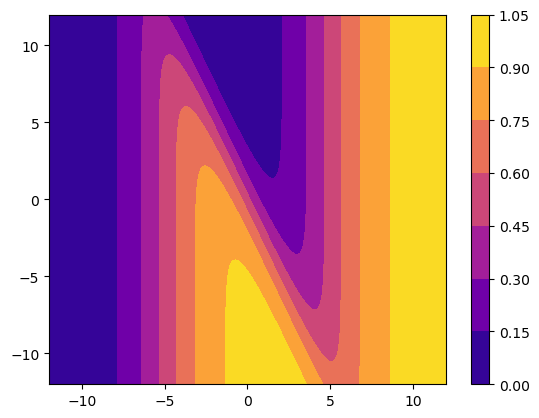

In [3]:
data = mg.generate(1e4)
n_grid=1000
line = np.linspace(-12,12,n_grid)
X,Y = np.meshgrid(line,line)
Z=mg._prob(np.vstack([X.flatten(),Y.flatten()]).T).reshape(n_grid,n_grid)
plt.contourf(X,Y,Z,cmap='plasma')
plt.colorbar()
#sns.scatterplot(data=data, x=0, y=1, hue='target', style='group',palette='bright',alpha=0.3)

In [4]:
from models import LogisticRegression as gdLR
lr = gdLR(loss='square',device='cpu').fit(data.drop(['target','group'],axis=1).values, data['target'].values,lr=1e-6)

In [5]:
lr.predict_proba(data.drop(['target','group'],axis=1).values)

array([0.02260397, 0.29931274, 0.00334277, ..., 0.9542734 , 0.8049909 ,
       0.86998504], dtype=float32)

In [6]:
(lr.predict(data.drop(['target','group'],axis=1).values) == data['target'].values).mean()

0.5398

In [7]:
((mg._prob(data.drop(['target','group'],axis=1))>1/2).astype(int)== data['target'].values).mean()

0.7253

In [8]:
mmse=mg.mmse_estimate(1e7)

In [9]:
def train_MMSE(frame:pd.DataFrame, lam:float = 0) -> tuple[np.ndarray, np.ndarray]:
    data = frame.copy()
    X = data.drop(['target','group'],axis=1)
    y = data['target']

    Var_X = np.cov(X, rowvar=False, bias=True) 
    Cov_XY = np.dot((X - X.mean(axis=0)).T, y-y.mean()) / (len(y))

    w_ERM = np.linalg.solve(Var_X + lam * np.eye(Var_X.shape[0]),Cov_XY)

    b_ERM = 1/2 - X.mean(axis=0)@w_ERM

    return w_ERM, b_ERM

In [10]:
def MSE(y_pred: np.ndarray, y_true:np.ndarray) -> float:
    return ((y_pred - y_true)**2).mean()

In [11]:
def pred(X: np.ndarray, w:np.ndarray, b:float) -> np.ndarray:
    return (X@w + b > 1/2).astype(int)

In [12]:
results = pd.DataFrame(columns=['mse','delta_A','lambda','seed'])
for seed in range(10):
    mg.rng = np.random.default_rng(seed)
    data = mg.generate(1e2)
    for lam in np.linspace(0,3, 100):
        w_ERM, b_ERM = train_MMSE(data, lam)
        delta_a = mg.model_mmse_estimate(w_ERM,b_ERM,1e6)
        results.loc[len(results)] = (MSE(pred(data.drop(['target','group'],axis=1),w_ERM , b_ERM), data['target']) ,delta_a, lam, seed)

KeyboardInterrupt: 

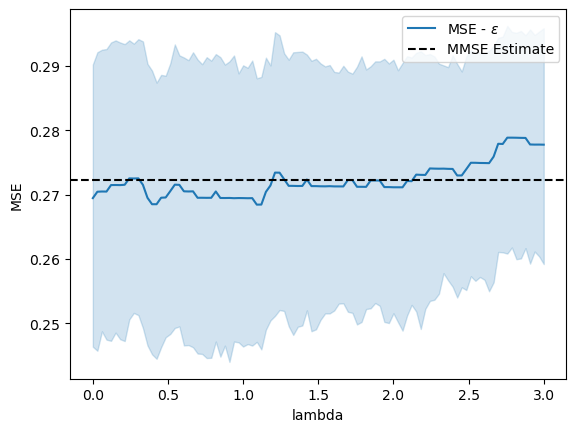

In [ ]:
#sns.lineplot(data=results, x='lambda',y='mse')
#sns.lineplot(data=results, x='lambda',y='delta_A')
sns.lineplot(data=results, x='lambda',y=results['mse'] - results['delta_A'] - np.sqrt(np.log(1/0.05)/2e2), label='MSE - $\epsilon$')
plt.axhline(mmse,0,1,linestyle='--', color='black',label='MMSE Estimate')
plt.ylabel('MSE')
plt.legend()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
sigma_results = pd.DataFrame(columns=['mse','delta_A','sigma','seed','mmse','lambda'])
for seed in range(10):
    mg.rng = np.random.default_rng(seed)
    for sigma in np.linspace(1,10, 50):
        l=None
        print(sigma)
        mg.sigma = sigma* np.eye(2)
        data = mg.generate(1e6)
        LR = gdLR(loss='square',device='cpu').fit(data.drop(['target','group'],axis=1).values, data['target'].values,lr=1e-6)
        #w_ERM = LR.coef_
        #b_ERM = LR.intercept_
        #w_ERM, b_ERM = train_MMSE(data, l)
        #lin_mse = MSE(pred(data.drop(['target','group'],axis=1),w_ERM , b_ERM), data['target'])
        lin_mse = MSE(LR.predict_proba(data.drop(['target','group'],axis=1).values), data['target'].values)
        test = mg.generate(1e6)
        delta_a = np.power(LR.predict_proba(test.drop(['target','group'],axis=1).values) - mg._prob(test.drop(['target','group'],axis=1).values),2).mean()
        sigma_results.loc[len(sigma_results)] = ( lin_mse,delta_a, sigma, seed, mg.mmse_estimate(1e6),l)

KeyboardInterrupt: 

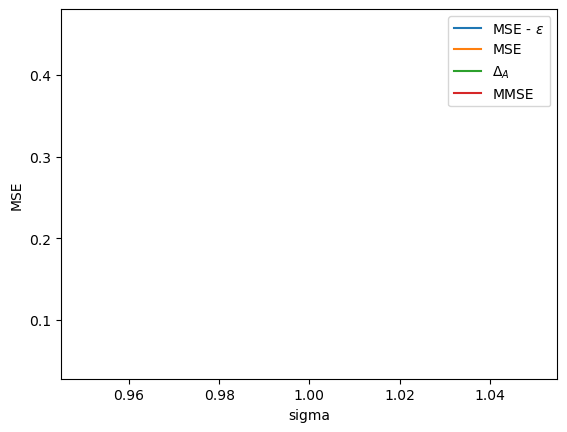

In [15]:
subset = sigma_results
sns.lineplot(data=subset, x='sigma',y=subset['mse'] - subset['delta_A'] - np.sqrt(np.log(1/0.05)/2e6), label='MSE - $\epsilon$')
sns.lineplot(data=subset, x='sigma',y='mse', label='MSE')
sns.lineplot(data=subset, x='sigma',y='delta_A', label='$\Delta_A$')
sns.lineplot(data=sigma_results, x='sigma',y=sigma_results['mmse'] , label='MMSE')
plt.ylabel('MSE')
plt.legend()